In [31]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.io import loadmat
import itertools

In [2]:
data = loadmat('../Data/ex7data2.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [3]:
X = data['X']

In [4]:
X.shape

(300, 2)

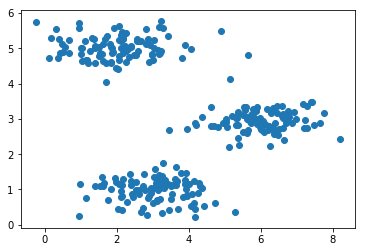

In [5]:
plt.scatter(X[:,0],X[:,1])
plt.show()

This problem is way less clear about what datasets to use for what problems. However, this looks like the same data as in figure 1, so I'll stick with it for the K-means clustering.

As usual I'm going to try building some things from scratch before ferreting out the standard implementation. There are 4 basic funcions needed.
1. Random initialization of centroids
2. Finding the closest centroid to each point
3. Calculating the centroid position as the mean of each point in the cluster.

In [6]:
def randomCentroidInit(X,K):
    permInd = np.random.permutation(X.shape[0])
    return X[permInd[:K],:]

In [7]:
#My stupid manual kernel implementation from last time is paying off!
def nearestCentroid(X,centroids):
    tmpX = X.reshape(1,X.shape[0],X.shape[1])
    tmpCent = centroids.reshape(centroids.shape[0],1,centroids.shape[1])
    distMat = np.dot((tmpX - tmpCent)**2,np.ones(X.shape[1]))
    return distMat.argmin(0)

In [17]:
centroids = randomCentroidInit(X,3)

In [18]:
classes = nearestCentroid(X,centroids)

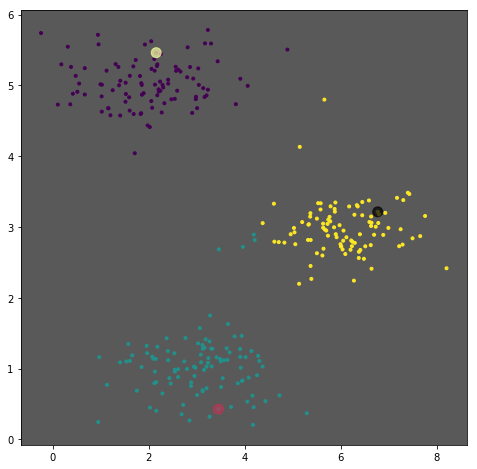

In [19]:
fig = plt.figure(figsize = [8,8])
ax = plt.axes(facecolor = [.35, .35, .35])
plt.scatter(X[:,0],X[:,1],c=classes,marker='.')
plt.scatter(centroids[:,0],centroids[:,1],s=100,c=range(3),alpha=.7,cmap = plt.get_cmap('inferno_r'))
plt.show()

So it works. It should be obvious that the centroids are a different color than their assigned cluster, which is for clarity. As it happens, it appears my random initialization has captured the three clusters pretty well. Of course, there's still some improvement to do. And that's why I need a function to recalculate the centroids.

In [20]:
def recalculateCentroids(X,K,classes):
    centroids = np.zeros((K,X.shape[1]))
    for k in range(K):
        centroids[k,:] = X[(classes==k),:].mean(axis=0)
    return centroids

In [21]:
new_cent = recalculateCentroids(X,3,classes)

In [22]:
new_cent

array([[1.98363152, 5.03043004],
       [3.06584667, 1.05078048],
       [6.08335155, 2.97769582]])

In [23]:
centroids

array([[2.15460139, 5.46282959],
       [3.45186351, 0.42784083],
       [6.77012767, 3.21411422]])

As expected, the new centroid isn't very far from the one I started with, which is a good sign that I did it right.

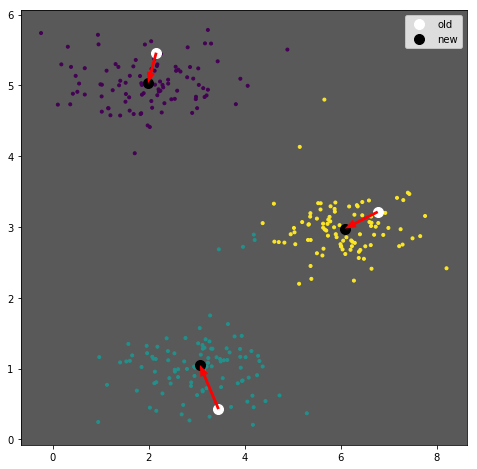

In [24]:
fig = plt.figure(figsize = [8,8])
ax = plt.axes(facecolor = [.35, .35, .35])
plt.scatter(X[:,0],X[:,1],c=classes,marker='.')
plt.scatter(centroids[:,0],centroids[:,1],s=100,c='w',label='old')
plt.scatter(new_cent[:,0],new_cent[:,1],s=100,c='k',label='new')
plt.quiver(centroids[:,0],centroids[:,1],new_cent[:,0]-centroids[:,0],new_cent[:,1]-centroids[:,1],\
           color='r',angles='xy',scale=1, scale_units='xy',\
           units='xy',width=.05,headwidth=3,headlength=4,headaxislength=4)
plt.legend()
plt.show()

Yup, the adjustment was correct!

Last thing is to define a cost function so I can judge which of several random initializations results in the lowest error after many iterations.

In [39]:
def kMeansCost(X,centroids,classes):
    m, K, N = (X.shape[0], centroids.shape[0], X.shape[1])
    J = 0
    for k in range(K):
        J += np.sum((X[(classes==k),:] - centroids[k,:].reshape(1,N))**2)
    return J/m

In [40]:
kMeansCost(X,centroids,classes)

1.3280338824304108

In [41]:
kMeansCost(X,new_cent,classes)

0.8999299417177345

Looks like it works to me. And moving the centroid lowers the cost, which is how it should work. Now to run a few random initializations to see what minimizes the cost.

In [56]:
rounds = 100
iterations = 10
K=3
cent_list, class_list = ([] for _ in range(2))
J_list = np.zeros((rounds,iterations))
for r in range(rounds):
    cent_list.append([])
    class_list.append([])
    cent_list[r].append(randomCentroidInit(X,K))
    for i in range(iterations):
        class_list[r].append(nearestCentroid(X,cent_list[r][i]))
        cent_list[r].append(recalculateCentroids(X=X,K=K,classes=class_list[r][i]))
        J_list[r,i] = kMeansCost(X=X,centroids=cent_list[r][i+1],classes=class_list[r][i])

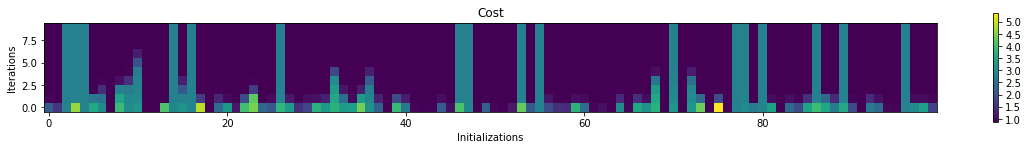

In [93]:
plt.figure(figsize = [20,2])
plt.imshow(J_list.T, origin='lower')
plt.ylabel('Iterations')
plt.xlabel('Initializations')
plt.title('Cost')
plt.colorbar()
plt.show()

So for the most part, it converges really quick. Let's pick the best one and see what it did. Also, I answered a question I had, which was: Why not just pick the initialization with the _initial_ lowest cost. But this figure shows initializations that started with high cost and still converged to the same answer as the other good ones.

In [66]:
round_min = J_list[:,-1].argmin()

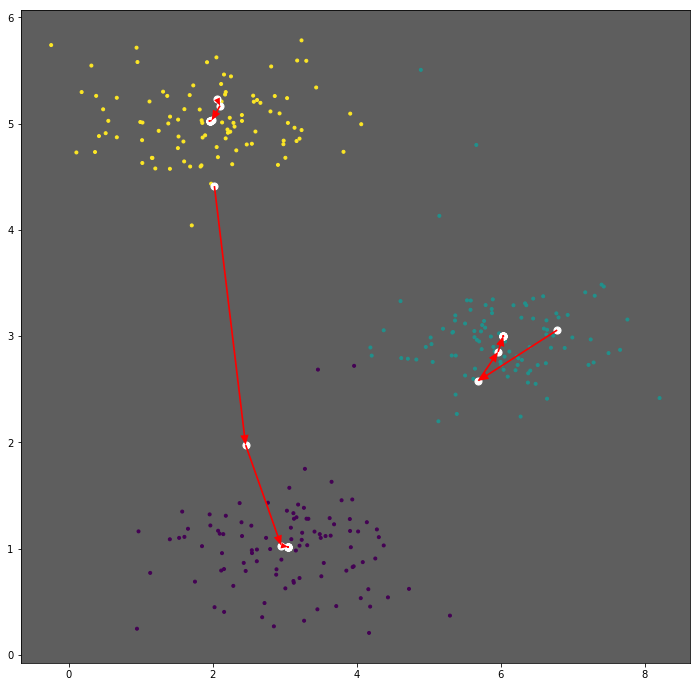

In [90]:
classes = class_list[round_min][-1]
fig = plt.figure(figsize = [12,12])
ax = plt.axes(facecolor = [.37, .37, .37])
plt.scatter(X[:,0],X[:,1],c=classes,marker='.')
for k in range(K):
    centroids = np.vstack([cent_list[round_min][i][k,:] for i in range(iterations+1)])
    plt.scatter(centroids[:,0],centroids[:,1],s=50,c='w')
    plt.quiver(centroids[:-1,0],centroids[:-1,1],centroids[1:,0]-centroids[:-1,0],centroids[1:,1]-centroids[:-1,1],\
           color='r',angles='xy',scale=1, scale_units='xy',\
           units='xy',width=.02,headwidth=5,headlength=6,headaxislength=6)
plt.show()

## K-means for image coloring

In [3]:
import png

In [94]:
f = open('../Data/bird_small.png','rb')
data = png.Reader(file = f).asDirect()
tmp = list(map(np.uint8,data[2]))

In [98]:
%%timeit
R = np.vstack([np.vstack([tmp[i][j] for j in range(0,len(tmp[i]),3)]) for i in range(len(tmp))]).reshape(data[0],data[1],1)
G = np.vstack([np.vstack([tmp[i][j] for j in range(1,len(tmp[i]),3)]) for i in range(len(tmp))]).reshape(data[0],data[1],1)
B = np.vstack([np.vstack([tmp[i][j] for j in range(2,len(tmp[i]),3)]) for i in range(len(tmp))]).reshape(data[0],data[1],1)
img = np.concatenate((R,G,B),axis=2)

114 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
%%timeit
img = np.zeros((data[0],data[1],3),dtype=np.uint8)
for i in range(data[0]):
    for j in range(data[1]):
        for k in range(3):
            img[i,j,k] = tmp[i][j*3+k]

29.3 ms ± 3.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


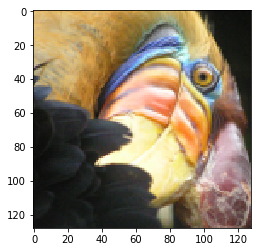

In [97]:
plt.imshow(img)
plt.show()

I'm not sure if there is a better way to import the image. I had to go find PyPNG and install it. I already had LibPNG installed, but that documentation was 8 years old. At least PyPNG is only 3 years old... And even after I imported the image, I'm not sure if there's a better way to assign it to a matrix. I've at least found the best of two options.